# ОИАД. Лабораторная работа №2

In [116]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.stats import norm
import math
from scipy.stats import fisher_exact

## Входные данные
Датасет: **datasets/students_simple.csv**
Выбираются 2 слобкика данных по формулам:
1) N % 5
2) N^2 % 5 + 5
где $N$ - номер в списке

In [117]:
df = pd.read_csv('students_simple.csv')

In [118]:
df.head(5)

,height,mass,income,iq,pages,age,bmi,work_exp,friends,test_time
0,159,45,430,95,24,20,3.533,26,5,8.5
1,160,61,640,115,32,25,2.623,63,7,6.2
2,161,56,610,111,24,28,2.875,94,10,6.8
3,162,48,330,97,24,19,3.375,16,4,12.0
4,162,54,420,105,60,23,3.000,49,2,7.5


In [119]:
N1 = 19 % 5
N2 = (19**2 % 5) + 5

cols = ["height","mass","income","iq","pages","age","bmi","work_exp","friends","test_time"]

print(cols[N1], cols[N2])

pages bmi


In [120]:
my_columns = ['pages', 'bmi']
df_selected = df[my_columns]
df_selected.head(5)

,pages,bmi
0,24,3.533
1,32,2.623
2,24,2.875
3,24,3.375
4,60,3.000


In [121]:
x = df_selected['pages']
y = df_selected['bmi']

## 1. Расчет корреляций

1. Фехнера

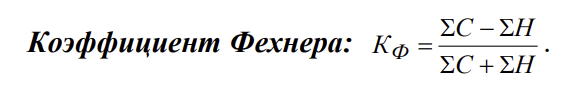


In [122]:
def calculate_mean(data):
    mean = sum(data) / len(data)
    return mean

In [123]:
def correlation_fechner(x, y):
    x_mean = calculate_mean(x)
    y_mean = calculate_mean(y)

    x_signs = np.sign(x - x_mean)
    y_signs = np.sign(y - y_mean)

    C = np.sum(x_signs == y_signs)
    H = np.sum(x_signs != y_signs)

    fechner = (C - H) / (C + H)

    return fechner

In [124]:
print(f'Коэффициент корреляции Фехнера: {correlation_fechner(x, y)}')

Коэффициент корреляции Фехнера: -0.4


2. Пирсона + доверительный интервал

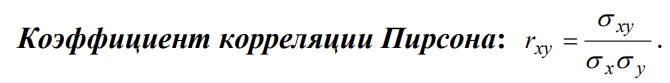

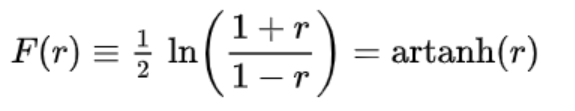

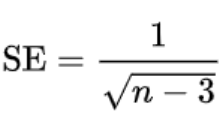

In [125]:
def cov(x, y):
    sum = 0
    x_mean = calculate_mean(x)
    y_mean = calculate_mean(y)

    for i in range(0, len(x)):
        sum += ((x[i] - x_mean) * (y[i] - y_mean))

    return sum/(len(x))

In [126]:
def correlation_pearson(x,y, confidence=0.95):

    n = len(x)

    covariance = cov(x,y)
    std_x = np.sqrt(np.sum((x - calculate_mean(x)) ** 2) / (n - 1))
    std_y = np.sqrt(np.sum((y - calculate_mean(y)) ** 2) / (n - 1))

    coef = covariance / (std_x * std_y)

    z = np.arctanh(coef)
    se_z = 1 / np.sqrt(n - 3)

    z_critical = stats.norm.ppf((1 + confidence) / 2)

    z_lower = z - z_critical * se_z
    z_upper = z + z_critical * se_z

    r_lower = np.tanh(z_lower)
    r_upper = np.tanh(z_upper)

    return pd.Series({
        'correlation': coef,
        'ci_lower': r_lower,
        'ci_upper': r_upper,
        'confidence_level': confidence
    })

In [127]:
pearson_correlation_results = correlation_pearson(x, y)
pearson_correlation_results_df = pd.DataFrame(pearson_correlation_results, columns=['value'])
pearson_correlation_results_df.head(4)

,value
correlation,-0.170522
ci_lower,-0.570029
ci_upper,0.294198
confidence_level,0.950000


3. Спирмена

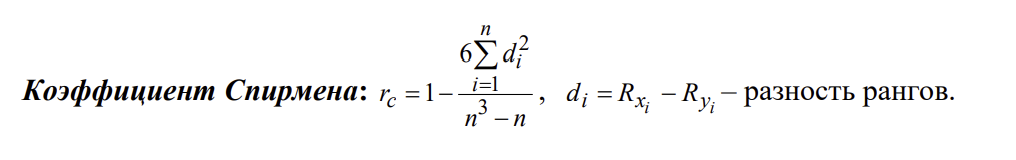

In [128]:
def correlation_spirmen(x,y):
    n = len(x)

    rank_x = x.rank(method='average')
    rank_y = y.rank(method='average')

    d = rank_x - rank_y

    spearman_corr = 1 - (6 * np.sum(d**2)) / (n**3 - n)

    return spearman_corr

In [129]:
print(f'Коэффициент корреляции Спирмена: {correlation_spirmen(x, y)}')

Коэффициент корреляции Спирмена: -0.30000000000000004


4. Кенделла

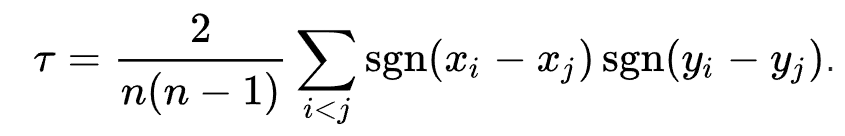

In [130]:
def correlation_kendell(x,y):
  n = len(x)
  sum_of_products = 0

  for i in range(n):
    for j in range(i + 1, n):
      sgn_x = math.copysign(1, x[i] - x[j]) if (x[i] - x[j]) != 0 else 0
      sgn_y = math.copysign(1, y[i] - y[j]) if (y[i] - y[j]) != 0 else 0
      sum_of_products += sgn_x * sgn_y

  tau = (2 * sum_of_products) / (n * (n - 1))

  return tau

In [131]:
print(f'Коэффициент корреляции Кенделла: {correlation_kendell(x, y)}')

Коэффициент корреляции Кенделла: -0.22631578947368422


* Все рассчитанные коэффициенты корреляции оказались отрицательными, что указывает на наличие обратной связи между количеством прочитанных страниц и ИМТ. Однако сила этой связи оценивается как слабая.

* Коэффициент Фехнера (-0.4): Указывает на то, что в большинстве случаев, когда одна переменная отклоняется от своего среднего значения в одну сторону, другая отклоняется в противоположную.

* Коэффициент Пирсона (-0.17): Показывает очень слабую линейную связь. Доверительный интервал (от -0.57 до 0.29) включает в себя ноль, что говорит о статистической незначимости линейной зависимости.

* Коэффициенты Спирмена (-0.30) и Кенделла (-0.23): Эти ранговые коэффициенты также подтверждают слабую обратную связь. Их значения немного выше, чем у Пирсона, что может указывать на то, что зависимость является монотонной, но не строго линейной.

## 2. Визуализация

1. Гистограммы


In [132]:
def built_hist(data):
  plt.hist(data, bins=10, edgecolor='black', color='skyblue', alpha=0.7)
  plt.title("Гистограмма", fontsize=16)
  plt.xlabel("",fontsize=14)
  plt.ylabel("Частота", fontsize=14)
  plt.grid(axis='y', alpha=0.5)


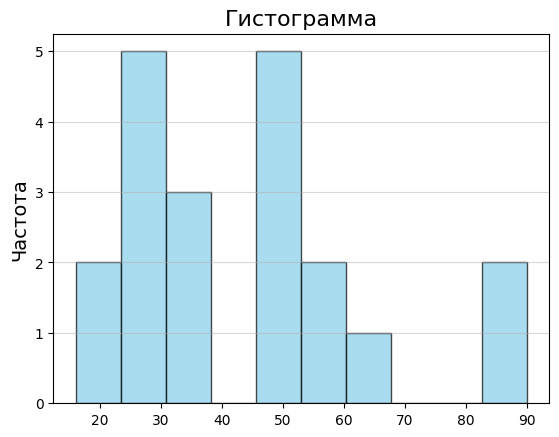

In [133]:
built_hist(x)

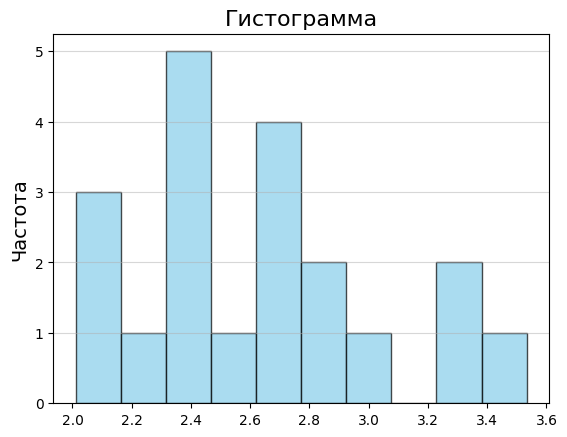

In [134]:
built_hist(y)

2. График рассеяния (scatter plot)

In [135]:
def build_scatter_plot(data):
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(data)), data, color='blue', alpha=0.7, s=50)
    plt.title("Scatter Plot", fontsize=14, fontweight='bold')
    plt.xlabel("", fontsize=12)
    plt.ylabel("", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

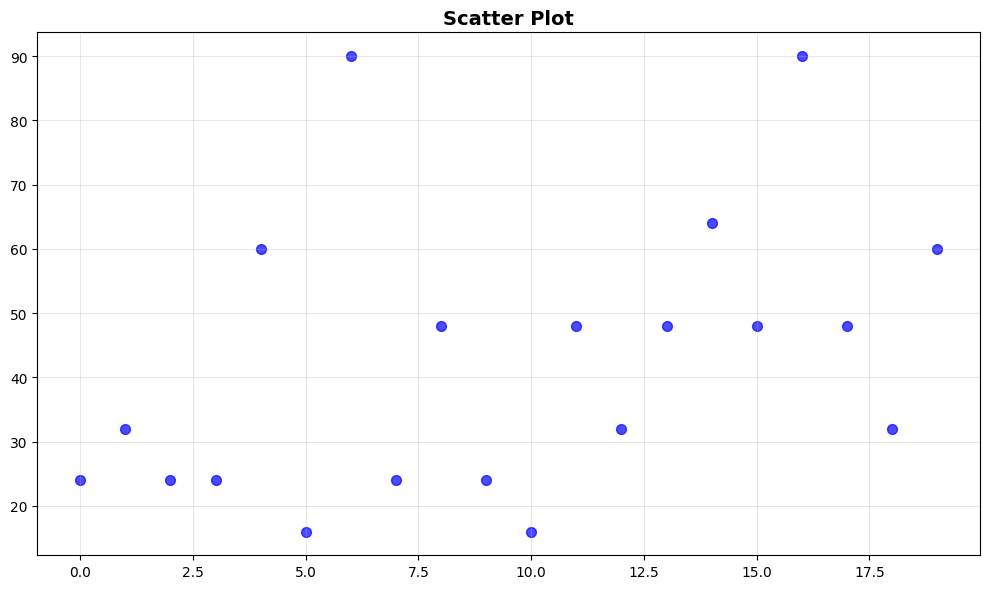

In [136]:
build_scatter_plot(x)

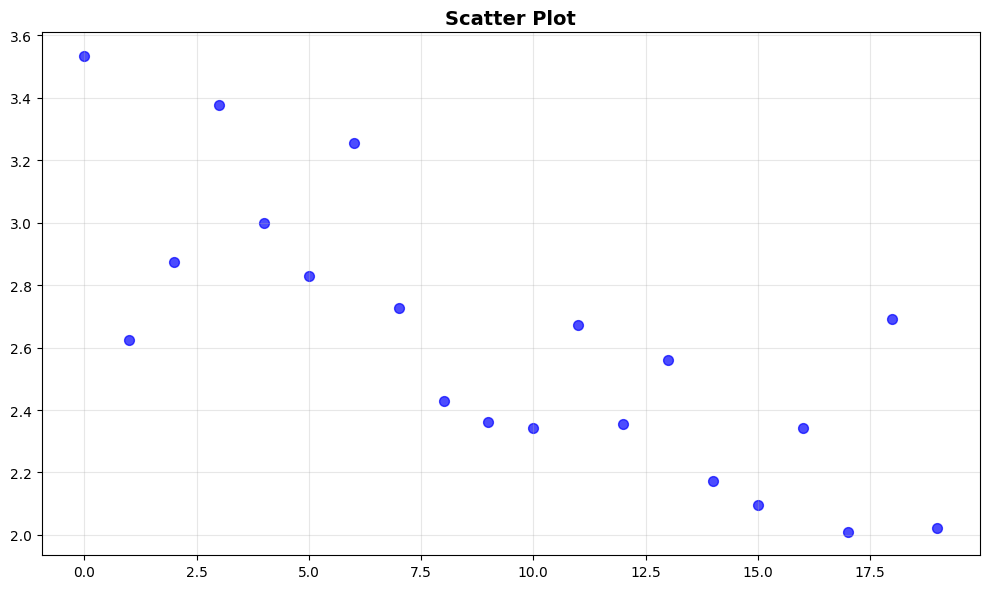

In [137]:
build_scatter_plot(y)

* Визуальный анализ данных подтверждает выводы, сделанные на основе коэффициентов корреляции.

* Гистограммы: Распределения pages и bmi не похожи на нормальное.

* График рассеяния (Scatter plot): Точки на графике образуют разреженное облако без четко выраженного тренда. Это визуально подтверждает очень слабую обратную линейную зависимость между переменными.

* Вывод: Данные распределены неравномерно, и визуально между переменными не наблюдается сильной зависимости.

## 3. Уравнение регрессии
Построить уравнение регрессии по видам:

Показать результаты на графиках

In [138]:
def regr_visualisation(x, y, y_pred):
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, color='blue', label='Исходные данные', s=50)
    sort_indices = np.argsort(x)
    x_sorted = x[sort_indices]
    y_pred_sorted = y_pred[sort_indices]
    plt.plot(x_sorted, y_pred_sorted, color='red', linewidth=2, label='Линия регрессии')

    plt.title('', fontsize=16)
    plt.xlabel('X', fontsize=12)
    plt.ylabel('Y', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

1. линейная, $y=w_1 x + w_0$

In [139]:
def linear_regression_coefs(x, y):
    n = len(x)
    w1 = (n * np.sum(x * y) - np.sum(x) * np.sum(y)) / (n * np.sum(x**2) - np.sum(x)**2)
    w0 = (np.sum(y) - w1 * np.sum(x)) / n

    return w0, w1

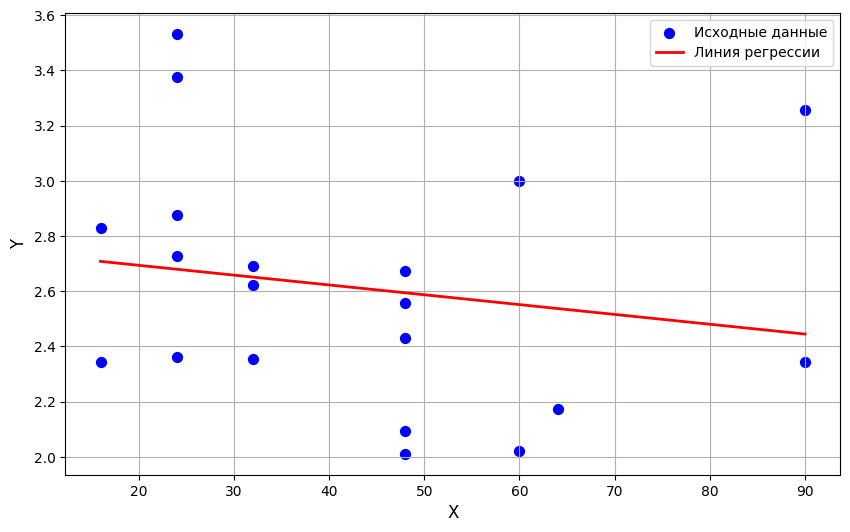

In [140]:
lin_w0, lin_w1 = linear_regression_coefs(x, y)

y_pred = lin_w1 * x + lin_w0

regr_visualisation(x, y, y_pred)

2. квадратичная, $y = w_2 x^2 + w_1 x + w_0$

In [141]:
def quadratic_regressio_coefs(x, y):
    X = np.c_[np.ones(len(x)), x, x**2]
    return np.linalg.inv(X.T @ X) @ X.T @ y

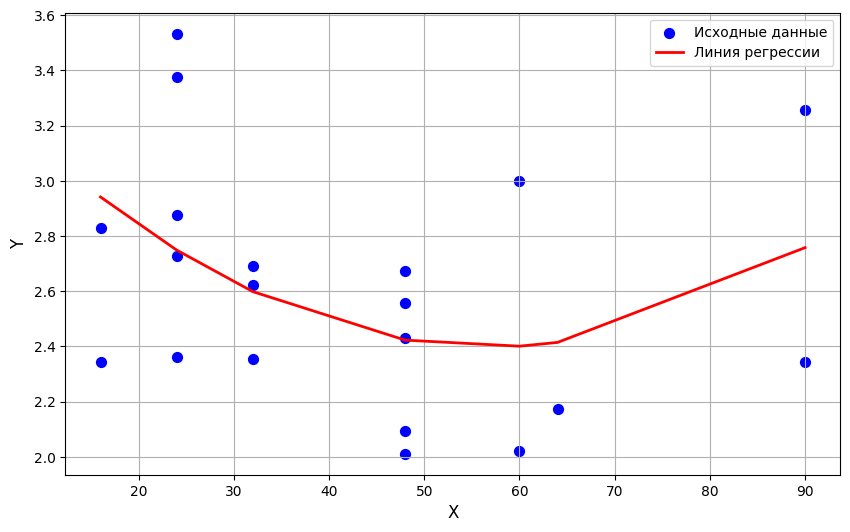

In [142]:
quad_w0, quad_w1, quad_w2 = quadratic_regressio_coefs(x, y)

y_pred = quad_w2 * x*x + quad_w1*x + quad_w0

regr_visualisation(x, y, y_pred)

3. гиперболическая, $y = \frac{w_1}{x} + w_0$

In [143]:
def hyperbolic_regression_coefs(x, y):
  X = np.column_stack([np.ones(len(x)), 1/x])
  return np.linalg.inv(X.T @ X) @ X.T @ y

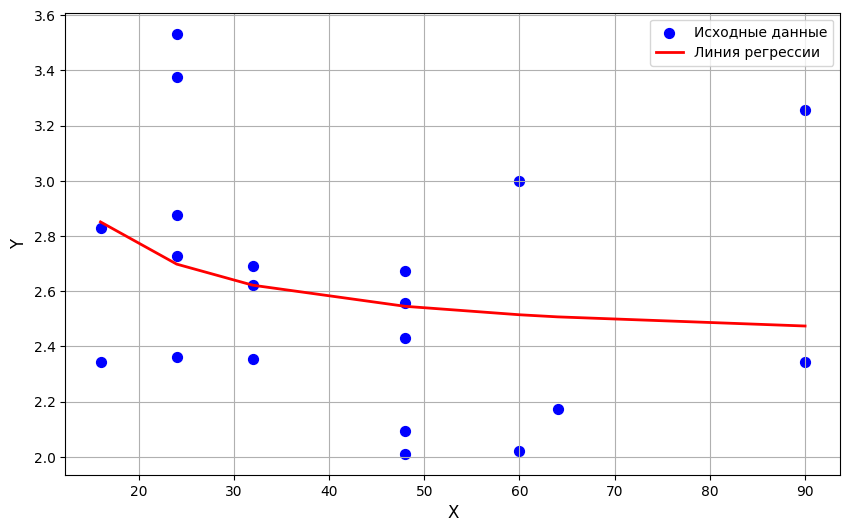

In [144]:
hyp_w0, hyp_w1 = hyperbolic_regression_coefs(x, y)

y_pred = hyp_w1 / x + hyp_w0

regr_visualisation(x, y, y_pred)

4. показательная, $y = w_1^x \cdot w_0$

In [145]:
# ln(y) = ln(w0) + x * ln(w1)

def exp_regression_coefs(x, y):
  mask = y > 0

  x_safe = x[mask]
  y_safe = y[mask]

  ln_y = np.log(y_safe)

  w0_log, w1_log = linear_regression_coefs(x_safe, ln_y)

  w0 = np.exp(w0_log)
  w1 = np.exp(w1_log)

  return w0, w1

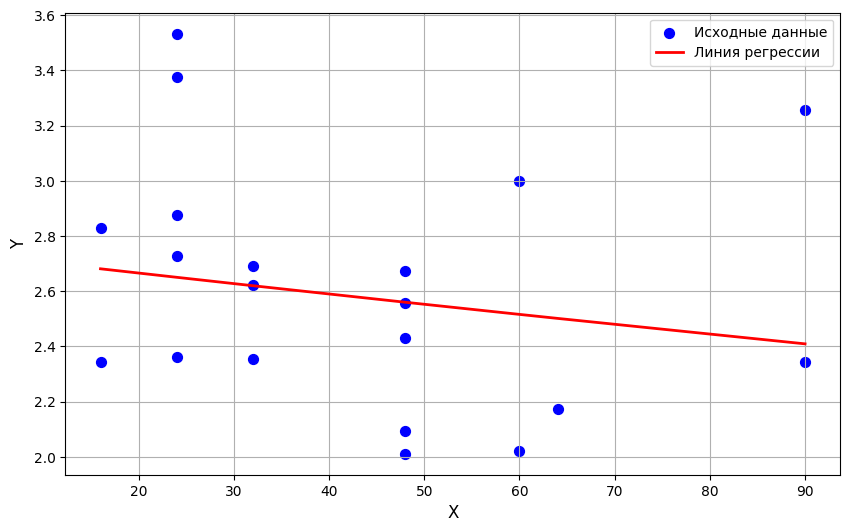

In [146]:
exp_w0, exp_w1 = exp_regression_coefs(x, y)

y_pred = (exp_w1 ** x) * exp_w0

regr_visualisation(x, y, y_pred)

* Были построены четыре модели регрессии для описания зависимости bmi от pages.
* Ни одна модель не описывает адекватно имеющиеся данные.
* Ни одна модель не может считаться надежной для прогнозирования.

## 4. Проверка уравнения регрессии
Для наилучшего и наихудшего уравнения регрессии проверить соотвествие модели данным с помощью критерия Фишера

In [147]:
statistic, p_value = fisher_exact([lin_w1 * x + lin_w0, y])

print(f"statistic: {statistic}")
print(f"p-value: {p_value}")

statistic: 1.846207238682829e-08
p-value: 1.0


In [148]:
statistic, p_value = fisher_exact([quad_w2 * x*x + quad_w1*x + quad_w0, y])

print(f"statistic: {statistic}")
print(f"p-value: {p_value}")

statistic: 1.846207238682829e-08
p-value: 1.0


In [149]:
statistic, p_value = fisher_exact([hyp_w1 / x + hyp_w0, y])

print(f"statistic: {statistic}")
print(f"p-value: {p_value}")

statistic: 1.846207238682829e-08
p-value: 1.0


In [150]:
statistic, p_value = fisher_exact([(exp_w1 ** x) * exp_w0, y])

print(f"statistic: {statistic}")
print(f"p-value: {p_value}")

statistic: 1.846207238682829e-08
p-value: 1.0


Statistic: 1.846e-08 (практически 0)
Это означает, что ваши выборочные данные почти идеально совпадают с тем, чего можно было ожидать, если бы нулевая гипотеза была верна.

p-value: 1.0 (максимально возможное значение)
Это говорит о том, что результат статистически абсолютно незначим.

## 5. Выводы
Сделать вывод по каждому пункту

см. выше